In [1]:

# General imports.import pprint
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pprint

# ML-related imports
import optuna
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

# Huggingface datasets.
from datasets import load_dataset

# Comparison of Bayesian Optimization Frameworks

In this notebook we are going to compare different bayesian optimization libraries against each other. To compare our results we will use [Huggingfaces spotify tracks dataset](https://huggingface.co/datasets/maharshipandya/spotify-tracks-dataset) dataset. We performed a short EDA on this dataset in [notebooks/eda__spotify_tracks.ipynb](https://github.com/PeeteKeesel/bayes-opt-battle/blob/7fed8d739c1b02c84a1eff05c0d3a44cb108e686/notebooks/huggingface__spotify_tracks/eda__spotify_tracks.ipynb).  

## Global Settings

In [2]:
RANDOM_SEED = 42

In [3]:
dataset = load_dataset('maharshipandya/spotify-tracks-dataset')
print(f"Shape: {dataset.shape}")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /Users/cwoest/.cache/huggingface/datasets/maharshipandya___csv/maharshipandya--spotify-tracks-dataset-54ededad57b062e8/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Shape: {'train': (114000, 21)}


In [4]:
df = pd.DataFrame(dataset.get('train'))
print(f"Shape: {df.shape}")
df.info()

Shape: (114000, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 16  

In [5]:
INT_FEATURES = df.select_dtypes(include=['int64', 'int32']).columns.tolist()
print(f"There are {len(INT_FEATURES)} int features in the dataset")

FLOAT_FEATURES = df.select_dtypes(include=['float64', 'float32']).columns.tolist()
print(f"There are {len(FLOAT_FEATURES)} float features in the dataset")

FEATURES = INT_FEATURES + FLOAT_FEATURES
TARGET_PRIOR = 'popularity'

There are 6 int features in the dataset
There are 9 float features in the dataset


In [6]:
bins = np.arange(0, 101, 10)
labels = np.arange(0, len(bins)-1, 1)
assert len(bins) == len(labels)+1, f"len(bins) = {len(bins)} != {len(labels)}+1 = len(labels)"

df['popularity_bucket'] = pd.cut(df[TARGET_PRIOR], 
                                 bins=bins, 
                                 labels=labels, 
                                 include_lowest=True)

TARGET = 'popularity_bucket' 
df['popularity_bucket'].value_counts()     

popularity_bucket
0    23462
4    18904
2    17579
3    15570
5    14200
1    10715
6     8724
7     3892
8      886
9       68
Name: count, dtype: int64

In [7]:
def predict_and_summarize(X_train_scaled,
                          X_test_scaled, 
                          y_train, 
                          y_test,
                          clf,
                          model_type):

    y_pred_train = clf.predict(X_train_scaled)
    train_acc = accuracy_score(y_train, y_pred_train)
    train_prec = precision_score(y_train, y_pred_train, average='macro', zero_division=0)
    train_rec = recall_score(y_train, y_pred_train, average='macro', zero_division=0)
    train_f1 = f1_score(y_train, y_pred_train, average='macro', zero_division=0)

    y_pred = clf.predict(X_test_scaled)
    test_acc = accuracy_score(y_test, y_pred)
    test_prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    test_rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    test_f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

    print(f"""
    Performance Results : {model_type} 
    ========================================
                    {'Train':<10}{'Test':<10}
        Accuracy  : {train_acc:<10.4f}{test_acc:<10.4f}
        Precision : {train_prec:<10.4f}{test_prec:<10.4f}
        Recall    : {train_rec:<10.4f}{test_rec:<10.4f}
        F1-Score  : {train_f1:<10.4f}{test_f1:<10.4f}
    """)

    return {'y_pred_train': y_pred_train, 'y_pred_test': y_pred}

## Dataset Preparation

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df[FEATURES], 
                                                    df[TARGET], 
                                                    test_size=0.15,
                                                    random_state=RANDOM_SEED,
                                                    stratify=df[TARGET])
print(f"""
Shapes
======
    train: {X_train.shape}
    test : {X_test.shape}      
""")


Shapes
    train: (96900, 15)
    test : (17100, 15)      



In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Bayesian Hyperparameter Optimization

Now we will tune the models hyperparameters using different libraries provided by Python.

We will use `Precision` as our optimization metric.

In [10]:
X_tra, X_val, y_tra, y_val = train_test_split(X_train,
                                              y_train, 
                                              test_size=0.2, 
                                              random_state=RANDOM_SEED,
                                              stratify=y_train)
print(f"""
Shapes
======
    train : {X_tra.shape}
    val   : {X_val.shape}
    test  : {X_test.shape}
""")


Shapes
    train : (77520, 15)
    val   : (19380, 15)
    test  : (17100, 15)



---

## `Optuna`

In [26]:
N_TRIALS = 20

```python 

param_dist = {
    'n_estimators': trial.suggest_int('n_estimators', 50, 300, log=True),
    'max_depth': trial.suggest_int('max_depth', 2, 15),
    'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),
    'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 1.0),
    'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2', None]),
    'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
    'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
    'random_state': 42,  # Fixed random_state or you can vary it as well
}
```

In [27]:
accuracies_train, precisions_train, recalls_train, f1s_train = [], [], [], []
accuracies_val, precisions_val, recalls_val, f1s_val = [], [], [], []
accuracies_test, precisions_test, recalls_test, f1s_test = [], [], [], []

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300, log=True)
    max_depth = trial.suggest_int('max_depth', 2, 15)
    min_samples_split = trial.suggest_float('min_samples_split', 0.1, 1.0)
    min_samples_leaf = trial.suggest_float('min_samples_leaf', 0.1, 1.0)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2', None])
    # bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])    
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            # bootstrap=bootstrap,
            criterion=criterion,
            random_state=RANDOM_SEED
        ))
    ])
        
    pipeline.fit(X_tra, y_tra)

    y_pred_train = pipeline.predict(X_tra)
    y_pred_val = pipeline.predict(X_val)
    y_test_pred = pipeline.named_steps['classifier'].predict(X_test_scaled)
    
    prec_train = precision_score(y_tra, y_pred_train, average='macro', zero_division=0)
    prec_val = precision_score(y_val, y_pred_val, average='macro', zero_division=0)
    prec_test = precision_score(y_test, y_test_pred, average='macro', zero_division=0)

    precisions_train.append(prec_train)
    precisions_val.append(prec_val)
    precisions_test.append(prec_test)

    return prec_val

In [28]:
start_time = time.time()

# Creating a study and running Optuna optimization.
study = optuna.create_study(study_name='my_optuna_study',
                            direction='maximize')
study.optimize(objective, n_trials=N_TRIALS)

elapsed_time = time.time() - start_time
elapsed_minutes, elapsed_seconds = int(elapsed_time // 60), int(elapsed_time % 60)

[I 2023-10-08 23:29:46,050] A new study created in memory with name: my_optuna_study
[I 2023-10-08 23:29:51,531] Trial 0 finished with value: 0.020583075335397317 and parameters: {'n_estimators': 251, 'max_depth': 8, 'min_samples_split': 0.3145366925973308, 'min_samples_leaf': 0.792390447432178, 'max_features': 'sqrt', 'criterion': 'entropy'}. Best is trial 0 with value: 0.020583075335397317.
/users/cwoest/Applications/anaconda3/envs/bayes_opt_battle/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[I 2023-10-08 23:30:04,348] Trial 1 finished with value: 0.075435949989752 and parameters: {'n_estimators': 294, 'max_depth': 6, 'min_samples_split': 0.3101073944250894, 'min_samples_leaf': 0.19965445372520

In [ ]:
# The searched optimal parameters.
best_params = study.best_params

# Create the pipeline with the searched optimal parameters.
best_rfc = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        min_samples_split=best_params['min_samples_split'],
        min_samples_leaf=best_params['min_samples_leaf'],
        max_features=best_params['max_features'],
        # bootstrap=best_params['min_samples_leaf'],
        criterion=best_params['criterion'],       
        random_state=RANDOM_SEED,
    ))
])

# Train the final model on the searched optimal parameters.
best_rfc.fit(X_train_scaled, y_train)

# Train metrics.
y_train_pred = best_rfc.predict(X_train_scaled)
train_acc = accuracy_score(y_train, y_train_pred)
train_prec = precision_score(y_train, y_train_pred, average='macro', zero_division=0)
train_rec = recall_score(y_train, y_train_pred, average='macro', zero_division=0)
train_f1 = f1_score(y_train, y_train_pred, average='macro', zero_division=0)

# Test metrics.
y_test_pred = best_rfc.predict(X_test_scaled)
test_acc = accuracy_score(y_test, y_test_pred)
test_prec = precision_score(y_test, y_test_pred, average='macro', zero_division=0)
test_rec = recall_score(y_test, y_test_pred, average='macro', zero_division=0)
test_f1 = f1_score(y_test, y_test_pred, average='macro', zero_division=0)

print(f"""
Optuna Results
==============
                {'Train':<10}{'Test':<10}{'Delta(train,test)':<20}
    Accuracy  : {train_acc:<10.4f}{test_acc:<10.4f}{test_acc-train_acc:10.4f}
    Precision : {train_prec:<10.4f}{test_prec:<10.4f}{test_prec-train_prec:10.4f}
    Recall    : {train_rec:<10.4f}{test_rec:<10.4f}{test_rec-train_rec:10.4f}
    F1-Score  : {train_f1:<10.4f}{test_f1:<10.4f}{test_f1-train_f1:10.4f}

Tuning time: {elapsed_minutes} min {elapsed_seconds} sec

Best parameters:
""")
pp = pprint.PrettyPrinter()
pp.pprint(best_params)

InvalidParameterError: The 'bootstrap' parameter of RandomForestClassifier must be an instance of 'bool', an instance of 'numpy.bool_' or an instance of 'int'. Got 0.4522547601528132 instead.

#### Plots

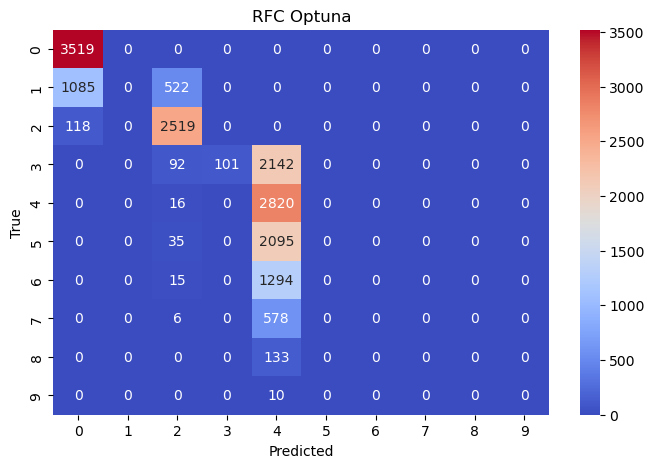

In [25]:
cm = confusion_matrix(y_test, y_test_pred)
class_labels = np.unique(y_test)

plt.figure(figsize=(8, 5))
sns.heatmap(cm, 
            annot=True, 
            cmap='coolwarm', 
            fmt='d', 
            xticklabels=class_labels, 
            yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('RFC Optuna')

plt.savefig('../../imgs/spotify_tracks/rfc_cm_optuna.png', dpi=300, bbox_inches='tight')

plt.show()

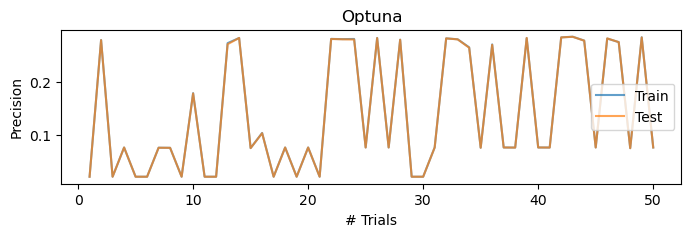

In [27]:
plt.figure(figsize=(8, 2))

plt.plot(np.arange(1, N_TRIALS+1, 1), precisions_train, label='Train', alpha=0.7, color='C0');
plt.plot(np.arange(1, N_TRIALS+1, 1), precisions_test, label='Test', alpha=0.7, color='C1');

plt.xlabel("# Trials");
plt.ylabel("Precision");
plt.legend();

plt.title("Optuna");
plt.show();